In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.family'] = 'DejaVu Sans'
from sklearn.cluster import AgglomerativeClustering, KMeans, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
random_state=17
X_train = np.loadtxt('samsung_train.txt')
y_train = np.loadtxt('samsung_train_labels.txt').astype(int)
X_test = np.loadtxt('samsung_test.txt')
y_test = np.loadtxt('samsung_test_labels.txt').astype(int)
# Проверим размерности
assert(X_train.shape == (7352, 561) and y_train.shape == (7352,))
assert(X_test.shape == (2947, 561) and y_test.shape == (2947,))

In [7]:
#Объединение обучающей и тестовой выборок
X = np.concatenate((X_train,X_test))
y = np.concatenate((y_train,y_test))

In [18]:
np.unique(y)
n_classes = np.unique(y).size

In [9]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [12]:
#Понижение размерности с помощью PCA
pca = PCA(random_state=random_state)
X_centered = X - X.mean(axis=0)
pca.fit(X_centered)
X_pca = pca.transform(X_centered)

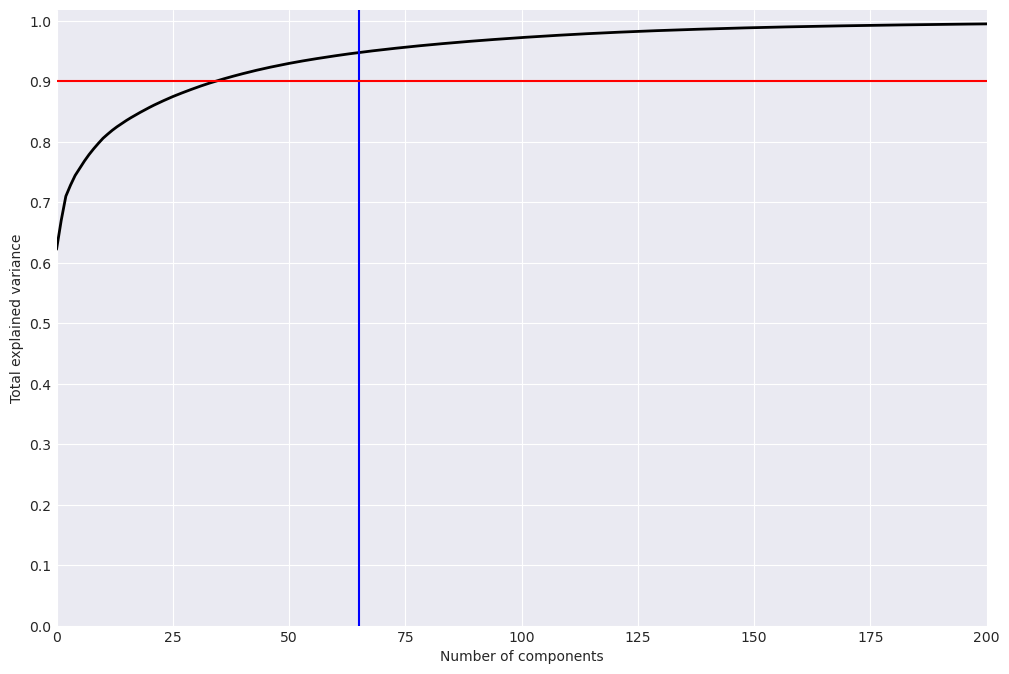

In [13]:
#Какое минимальное количество главных компонентов нужно выделить, чтобы объяснить 90% исходных данных?
plt.figure(figsize=(12, 8))
plt.plot(np.cumsum(pca.explained_variance_ratio_), color='k', lw=2)
plt.xlabel('Number of components')
plt.ylabel('Total explained variance')
plt.xlim(0, 200)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.axvline(65, c='b')
plt.axhline(0.9, c='r')
plt.show();

In [14]:
#Проценты дисперсии
for i, component in enumerate(pca.components_):
    print("{} component: {}% of initial variance".format(i + 1, 
          round(100 * pca.explained_variance_ratio_[i], 2)))

1 component: 62.23% of initial variance
2 component: 4.77% of initial variance
3 component: 4.02% of initial variance
4 component: 1.82% of initial variance
5 component: 1.61% of initial variance
6 component: 1.2% of initial variance
7 component: 1.19% of initial variance
8 component: 1.08% of initial variance
9 component: 0.96% of initial variance
10 component: 0.89% of initial variance
11 component: 0.84% of initial variance
12 component: 0.68% of initial variance
13 component: 0.64% of initial variance
14 component: 0.58% of initial variance
15 component: 0.52% of initial variance
16 component: 0.51% of initial variance
17 component: 0.47% of initial variance
18 component: 0.45% of initial variance
19 component: 0.43% of initial variance
20 component: 0.41% of initial variance
21 component: 0.41% of initial variance
22 component: 0.39% of initial variance
23 component: 0.37% of initial variance
24 component: 0.35% of initial variance
25 component: 0.35% of initial variance
26 compon

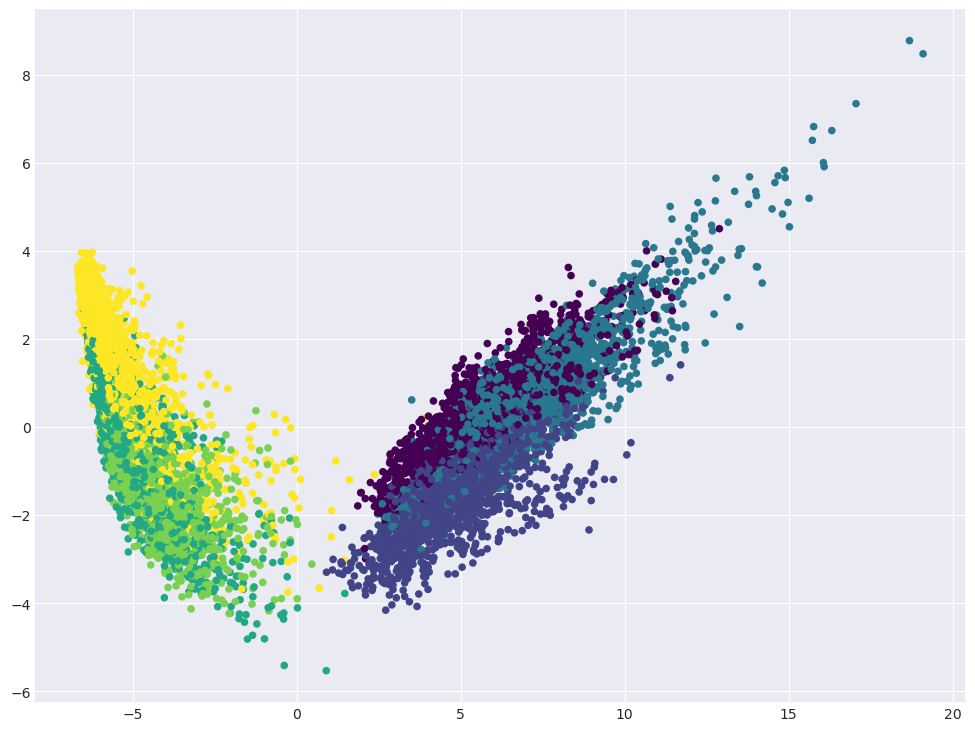

In [15]:
#Визуализируйте данные на первые две компоненты
X_reduced = pca.fit_transform(X)
plt.scatter(X_reduced[:,0],X_reduced[:,1],c=y,s=20,cmap="viridis")

In [20]:
kmeans = KMeans(n_clusters=n_classes,random_state=random_state,n_init=100).fit(X_reduced)

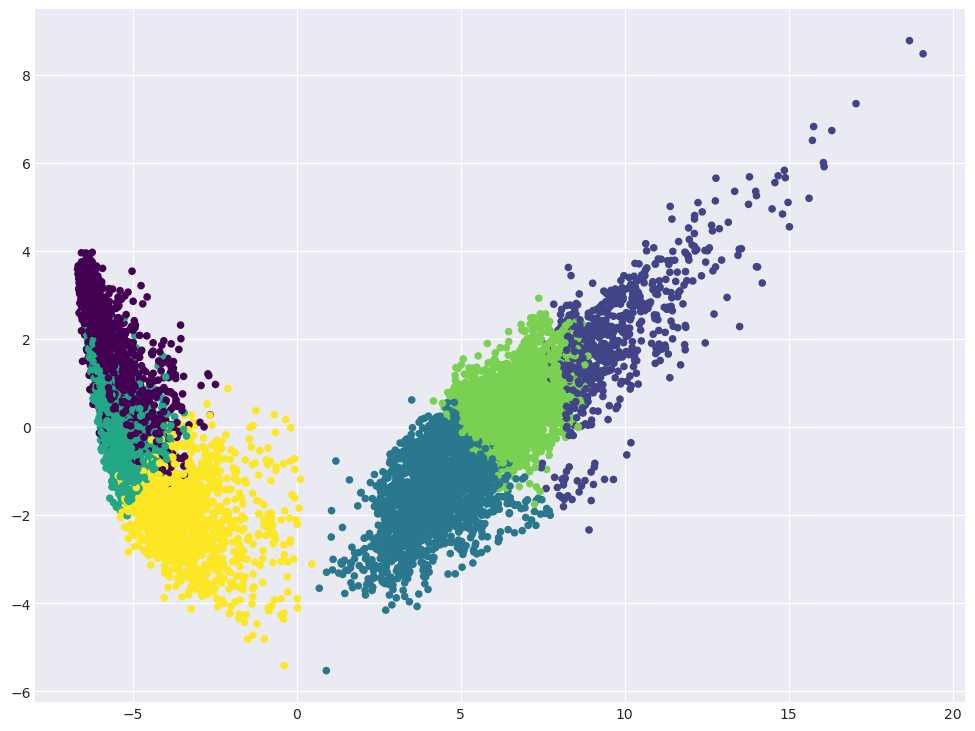

In [24]:
plt.scatter(X_reduced[:,0],X_reduced[:,1],c=kmeans.labels_,s=20,cmap="viridis")

In [25]:
tab = pd.crosstab(y, kmeans.labels_,margins=True)
tab.index = ['ходьба', 'подъем вверх по лестнице', 
             'спуск по лестнице', 'сидение', 'стояние', 'лежание', 'все']
tab.columns = ['cluster' + str(i+1) for i in range(6)] + ['все']
tab

,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,все
ходьба,0,150,704,0,868,0,1722
подъем вверх по лестнице,0,81,1166,0,297,0,1544
спуск по лестнице,0,455,187,0,764,0,1406
сидение,49,0,3,1253,0,472,1777
стояние,0,0,0,1232,0,674,1906
лежание,1761,0,12,0,0,171,1944
все,1810,686,2072,2485,1929,1317,10299


  0%|          | 0/6 [00:00<?, ?it/s]

C:\Users\sholo\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\sholo\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\sholo\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\sholo\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of

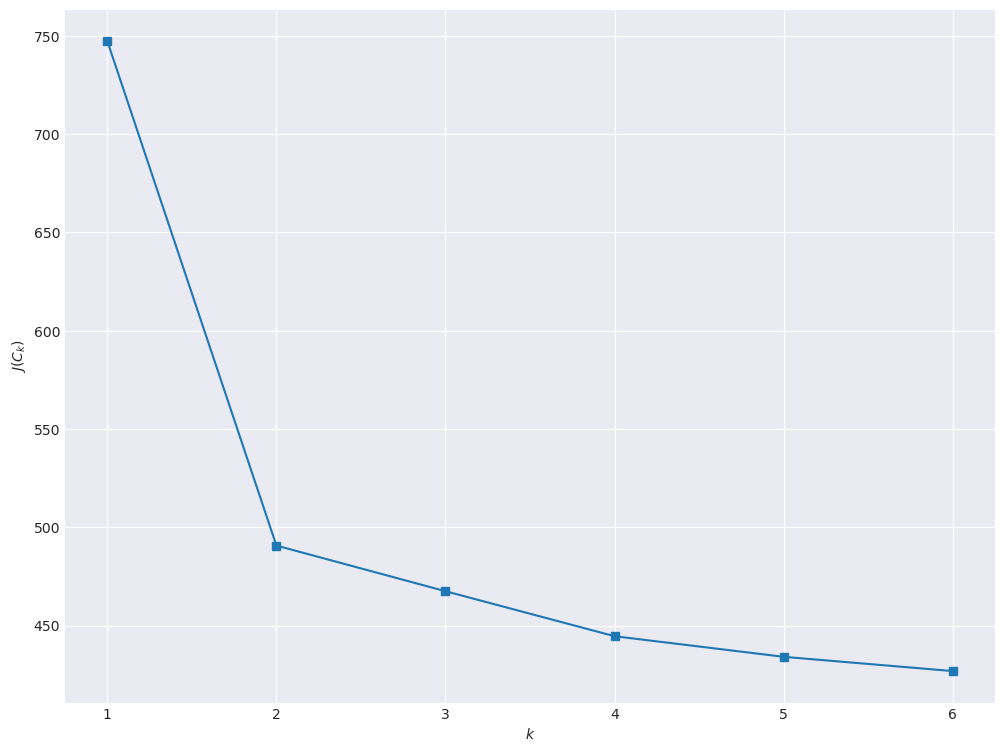

In [34]:
#Метод локтя
from tqdm.notebook import tqdm
from tqdm.notebook import tqdm_notebook
inertia=[]
for k in tqdm_notebook(range(1,n_classes+1)):
    kmeans = KMeans(n_clusters=k,random_state=random_state).fit(X)
    inertia.append(np.sqrt(kmeans.inertia_))
plt.plot(range(1, n_classes+1), inertia, marker='s');
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$');

In [38]:
import sklearn.metrics as metrics
ag = AgglomerativeClustering(n_clusters=n_classes,linkage="ward").fit(X_pca)
metrics.adjusted_rand_score(y, ag.labels_)

0.49090734475031733

In [39]:
metrics.adjusted_rand_score(y, kmeans.labels_)

0.46130889139748515

In [45]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
svc = LinearSVC(random_state=random_state)
svc_params = {'C': [0.001, 0.01, 0.1, 1, 10]}
best_svc = GridSearchCV(svc,svc_params,cv=3,n_jobs=-1)
best_svc.fit(X_train_scaled,y_train)
best_svc.best_params_

C:\Users\sholo\anaconda3\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\sholo\anaconda3\lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


{'C': 0.1}

In [46]:
best_svc.best_score_

0.9382506099134881

In [47]:
y_predicted = best_svc.predict(X_test_scaled)
tab = pd.crosstab(y_test,y_predicted,margins=True)
tab.index = ['ходьба', 'подъем вверх по лестнице', 'спуск по лестнице', 
             'сидение', 'стояние', 'лежание', 'все']
tab.columns = tab.index
tab

,ходьба,подъем вверх по лестнице,спуск по лестнице,сидение,стояние,лежание,все
ходьба,494,2,0,0,0,0,496
подъем вверх по лестнице,12,459,0,0,0,0,471
спуск по лестнице,2,3,414,1,0,0,420
сидение,0,4,0,426,61,0,491
стояние,0,0,0,15,517,0,532
лежание,0,0,0,0,11,526,537
все,508,468,414,442,589,526,2947


In [48]:
#StandardScaler, pca
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
pca = PCA(n_components=0.9,random_state=random_state)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)
svc = LinearSVC(random_state=random_state)
svc_params = {'C': [0.001, 0.01, 0.1, 1, 10]}
get_ipython().run_cell_magic('time', '', 'best_svc_pca = GridSearchCV(svc, svc_params, n_jobs=1, cv=3, verbose=1)\nbest_svc_pca.fit(X_train_pca, y_train);')
best_svc_pca.best_params_

Fitting 3 folds for each of 5 candidates, totalling 15 fits


C:\Users\sholo\anaconda3\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\sholo\anaconda3\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\sholo\anaconda3\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\sholo\anaconda3\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\sholo\anaconda3\lib\site-packages\sklearn\svm\_base

CPU times: total: 19.9 s
Wall time: 11.7 s


C:\Users\sholo\anaconda3\lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


{'C': 1}

In [49]:
best_svc_pca.best_score_

0.8998943094169531